# Cálculo da Aceleração (speedup) e Eficiência

---

## Introdução

Este caderno experimental tem por objetivo calcularmos a aceleração (*speedup*) e eficiência de uma operação quando esta pode ser calculada em paralelo. 

Utilizaremos como exemplo uma operação que consiste no processo de otimização de modelos de aprendizado de máquina. Inicialmente carregamos o conjunto de dados `Breast Cancer`, da biblioteca scikit learn, e em seguida, dividimos esses dados em conjuntos distintos para treinamento e teste. Definimos os hiperparâmetros, como o parâmetro de regularização e o tipo de kernel, juntamente com suas possíveis variações em um grid (param_grid). Criamos um classificador SVM (SVC) e utilizamos o objeto GridSearchCV para explorar sistematicamente as combinações de hiperparâmetros, empregando a validação cruzada para avaliar o desempenho. 

Ao término, recuperamos os hiperparâmetros ótimos e o melhor estimador com base nos resultados do grid search. 

Com esses melhores parâmetros em mãos, procedemos à avaliação do modelo no conjunto de teste. O GridSearchCV automatiza a busca exaustiva de hiperparâmetros e oferece o conjunto ideal para ajustar o modelo, aprimorando, assim, seu desempenho.

Ao empregar o GridSearchCV em um ambiente com múltiplos threads, é possível avaliar o speedup e a eficiência do processo de busca de hiperparâmetros. O speedup representa a aceleração obtida com o paralelismo, medindo a redução no tempo de execução à medida que mais threads são usados. A eficiência, por outro lado, indica o quão bem o processamento paralelo está sendo aproveitado, considerando a relação entre o número de threads e o speedup alcançado. Ao monitorar essas métricas, os profissionais de dados podem determinar o impacto da paralelização na eficiência do GridSearchCV, garantindo que os recursos computacionais sejam utilizados de forma otimizada e resultem em economia de tempo significativa

## Escopo

Este trabalho se concentra na avaliação do impacto do processamento paralelo, excluindo detalhes específicos sobre o aprendizado de máquina. A pesquisa explora o uso de múltiplos threads, para analisar como elas podem aprimorar a aceleração e eficiência da operação.

## Carga das bibliotecas

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from timeit import default_timer as timer
import pandas as pd

# setar variáeis de ambiente para execução sequencial
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

# Carregando o conjunto de dados de Câncer de Mama

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target

# Dividindo o conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definindo o dicionário de hiperparâmetros 

In [3]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],          # Parâmetro de regularização
    'kernel': ['linear', 'rbf'],  # Tipo de kernel
    'gamma': [0.001, 0.01, 0.1]  # Coeficiente do kernel
}

## Treinamento sequencial

Para restringir a utilização de somente um thread durante o processo de otimização, definimos o parâmetro `n_jobs = 1` da função `GridSearchCV`. 

De acordo com a documentação GrdiSearchCV:

```
n_jobsint, default=None - Número de trabalhos a serem executados em paralelo. "None" significa 1, a menos que esteja em um contexto de "joblib.parallel_backend". "-1" significa usar todos os processadores."
```
referência: [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)



In [4]:
# Criando o classificador SVM
svm = SVC()

# Criando um objeto GridSearchCV com execução sequencial
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=1)

# Ajustando o GridSearchCV
inicio = timer()
grid_search.fit(X_train, y_train)
fim = timer()
tempo = fim - inicio

# Obtendo os melhores parâmetros e estimador
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Melhores Parâmetros:", best_params)

# Avaliando o modelo no conjunto de teste
acuracia = best_estimator.score(X_test, y_test)
print("Acurácia no Conjunto de Teste:", acuracia)
print(f"Utilizando processamento em série o tempo de treinamento foi: {tempo:.02f}")


Melhores Parâmetros: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Acurácia no Conjunto de Teste: 0.956140350877193
Utilizando processamento em série o tempo de treinamento foi: 26.69


## Treinamento Paralelo

Vamos definir o parametro `n_jobs` para o número máximo de threads disponíveis no ambiente. Utilizamos a função `cpu_count`, da biblioteca `multiprocessing`, para contar a quantidade de threads disponíveis.

In [5]:
import multiprocessing as mp
n_threads = 2 * mp.cpu_count()
print(f"{n_threads} thread(s) disponíveis")

24 thread(s) disponíveis


Criamos a função a seguir para facilitar a execução do processo de treinamento o modelo com o conjunto de dados Câncer de Mama

In [6]:
def treinamento(n_jobs):
    # Criando o classificador SVM
    svm = SVC()

    # Criando um objeto GridSearchCV com execução paralela
    grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=n_jobs)

    # Ajustando o GridSearchCV
    inicio = timer()
    grid_search.fit(X_train, y_train)
    fim = timer()
    tempo = fim - inicio

    # Obtendo os melhores parâmetros e estimador
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    print("Melhores Parâmetros:", best_params)

    # Avaliando o modelo no conjunto de teste
    acuracia = best_estimator.score(X_test, y_test)
    print("Acurácia no Conjunto de Teste:", acuracia)
    print(f"Utilizando processamento com {n_jobs} thread(s) o tempo de treinamento foi: {tempo:.02f}")
    return tempo, acuracia


In [7]:
tempo_paralelo, acuracia = treinamento(n_threads)

Melhores Parâmetros: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Acurácia no Conjunto de Teste: 0.956140350877193
Utilizando processamento com 24 thread(s) o tempo de treinamento foi: 4.79


In [8]:
print(f"Podemos observar que não houve impacto na acurácia calculada de {acuracia}.")
print(f"O tempo de treinamento do modelo, no entanto, foi impactado e percebemos uma diminuição no tempo de treinamento em paralelo, com {n_threads} threads, em relação ao treinamento em série, de {tempo:.02f}s para {tempo_paralelo:.02f}s respectivamente")

Podemos observar que não houve impacto na acurácia calculada de 0.956140350877193.
O tempo de treinamento do modelo, no entanto, foi impactado e percebemos uma diminuição no tempo de treinamento em paralelo, com 24 threads, em relação ao treinamento em série, de 26.69s para 4.79s respectivamente


## Calculando Aceleração e Eficiência

Vamos agora repetir o treinamento para a quantidade de processos threads de 1 (execução que pode ser considerada sequencial) até a quantidade máxima de trabalhadores

Vamos coletar os tempos de execução de cada execução e calcular a aceleração e eficiência. Os dados serão salvos em um arquivo CSV `experimento_grupo_g.csv` para que possamos analisá-los posteriormente.

In [9]:
import multiprocessing as mp

n_threads = 2 * mp.cpu_count()

print(f"{n_threads} thread(s) disponíveis")

24 thread(s) disponíveis


In [10]:
import csv
csv_header = ["p", "time"]
with open('../data/experimento_resultado.csv', 'w') as file:
  writer = csv.writer(file)
  writer.writerow(["p", "tempo"]) # o cabeçalho do CSV
  for p in range(1, n_threads + 1):
    # Vamos executar o experimento
    tempo, acuracia = treinamento(p)
    # Salvar no arquivo CSV a tupla
    writer.writerow([p, tempo])



Melhores Parâmetros: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Acurácia no Conjunto de Teste: 0.956140350877193
Utilizando processamento com 1 thread(s) o tempo de treinamento foi: 26.83
Melhores Parâmetros: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Acurácia no Conjunto de Teste: 0.956140350877193
Utilizando processamento com 2 thread(s) o tempo de treinamento foi: 15.83
Melhores Parâmetros: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Acurácia no Conjunto de Teste: 0.956140350877193
Utilizando processamento com 3 thread(s) o tempo de treinamento foi: 10.47
Melhores Parâmetros: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Acurácia no Conjunto de Teste: 0.956140350877193
Utilizando processamento com 4 thread(s) o tempo de treinamento foi: 8.42
Melhores Parâmetros: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Acurácia no Conjunto de Teste: 0.956140350877193
Utilizando processamento com 5 thread(s) o tempo de treinamento foi: 7.36
Melhores Parâmetros: {'C': 1, 'gamma': 0.001, 'kerne

Conteúdo do arquivo com as medidas de desempenho

In [11]:
df_exp = pd.read_csv('../data/experimento_resultado.csv')
print(df_exp.to_string())

     p      tempo
0    1  26.830812
1    2  15.830576
2    3  10.465825
3    4   8.422607
4    5   7.358005
5    6   5.726616
6    7   7.674826
7    8   5.413484
8    9   4.781807
9   10   4.614215
10  11   5.461950
11  12   5.339526
12  13   4.090656
13  14   4.065910
14  15   4.096056
15  16   4.076816
16  17   4.248544
17  18   4.204084
18  19   4.147172
19  20   4.049942
20  21   4.237970
21  22   4.262131
22  23   4.160393
23  24   4.330997


In [12]:
tseq = df_exp.query('p == 1')['tempo'].iloc[0]
tseq
df_exp = df_exp.assign(seq = tseq)
df_exp = df_exp.assign(speedup = df_exp['seq']/df_exp['tempo'])
df_exp = df_exp.assign(eficiencia = df_exp['speedup']/df_exp['p'])
df_exp

,p,tempo,seq,speedup,eficiencia
0,1,26.830812,26.830812,1.000000,1.000000
1,2,15.830576,26.830812,1.694873,0.847436
2,3,10.465825,26.830812,2.563660,0.854553
3,4,8.422607,26.830812,3.185571,0.796393
4,5,7.358005,26.830812,3.646479,0.729296
5,6,5.726616,26.830812,4.685282,0.780880
6,7,7.674826,26.830812,3.495951,0.499422
7,8,5.413484,26.830812,4.956292,0.619537
8,9,4.781807,26.830812,5.611019,0.623447
9,10,4.614215,26.830812,5.814816,0.581482


Gerando os gráficos ilustrativos

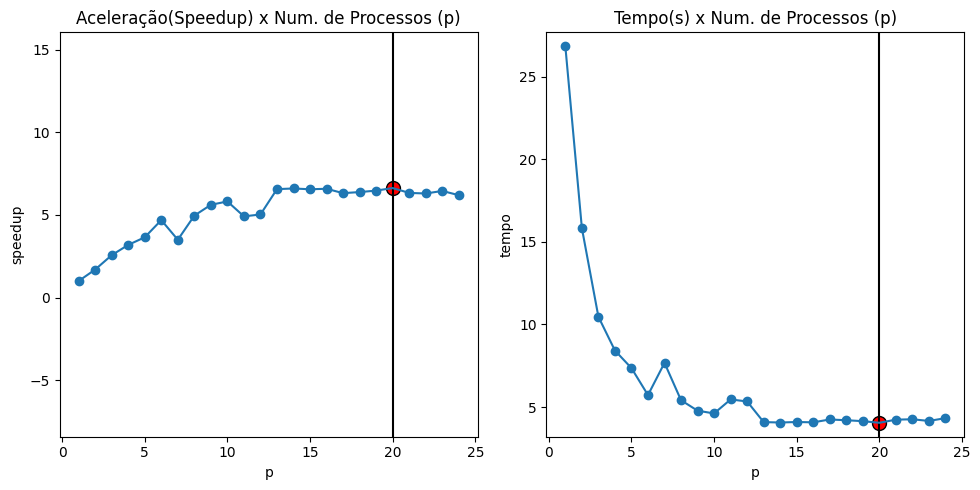

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Primeiro gráfico
plt.subplot(1, 2, 1)
plt.scatter(df_exp['p'], df_exp['speedup'])

indice_maior_speedup = df_exp['speedup'].idxmax()

plt.scatter(df_exp['p'][indice_maior_speedup], df_exp['speedup'][indice_maior_speedup], s=100, c='red', edgecolors='black')
plt.axvline(x=indice_maior_speedup+1, c="black")
plt.plot(df_exp['p'], df_exp['speedup'])
plt.axis('equal')
plt.ylabel('speedup')
plt.xlabel('p')
plt.title("Aceleração(Speedup) x Num. de Processos (p)")

# Segundo gráfico
plt.subplot(1, 2, 2)  # Subplot da direita
plt.scatter(df_exp['p'], df_exp['tempo'])

# Encontrar o índice do ponto com o maior valor de y
indice_menor_tempo = df_exp['tempo'].idxmin()

# Plote um círculo vermelho ao redor do ponto com o maior valor de y
plt.scatter(df_exp['p'][indice_menor_tempo], df_exp['tempo'][indice_menor_tempo], s=100, c='red', edgecolors='black')
plt.axvline(x=indice_menor_tempo+1, c="black")
plt.plot(df_exp['p'], df_exp['tempo'])
plt.axis('equal')
plt.ylabel('tempo')
plt.xlabel('p')
plt.title("Tempo(s) x Num. de Processos (p)")

# Ajuste o layout da figura
plt.tight_layout()

plt.show()

Analisamos o impacto da variação no número de processos em relação ao desempenho no treinamento de um modelo de classificação baseado na base de dados `Breast Cancer`. Os resultados revelaram um aumento inicial no Aceleração à medida que o número de processos aumentou, indicando uma melhoria no desempenho. No entanto, a partir de 20 processos, a aceleração diminuiu, sugerindo uma escalabilidade limitada. Ao mesmo tempo, o tempo de execução inicialmente diminuiu à medida que mais processos foram alocados, mas, a partir de 20 processos,começou a aumentar. É possível que isto ocorra em razão de overhead de comunicação e ineficiências na paralelização, limitando os ganhos possíveis com paralelização para o processo de treinamento do modelo de classificação utilizado, conforme preconiza a lei de Amhdal.